Capstone Project Deteksi Sampah (Bangkit 2024 Batch 1)

1. Import Required Libray

In [ ]:
!pip install split-folders
!pip install opencv-python-headless

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import splitfolders
from tensorflow import keras
from keras.applications import MobileNetV2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from sklearn import metrics

2. Load and Split Dataset

In [ ]:
dataset_path = "/content/drive/MyDrive/Gambar Sampah"

In [ ]:
class_names = sorted(os.listdir(dataset_path))
print(class_names)

['kaca', 'karton', 'kertas', 'logam', 'organik', 'plastik']


In [ ]:
class_dis = [len(os.listdir(dataset_path + f"/{name}")) for name in class_names]
class_dis

[453, 404, 610, 411, 420, 550]

In [ ]:
splitfolders.ratio(dataset_path,
                   output="data_sampah",
                   seed=42,
                   ratio=(.7, .2, .1),
                   group_prefix=None)

Copying files: 2848 files [01:04, 43.93 files/s] 


In [ ]:
training = os.path.join('data_sampah', 'train')
validation = os.path.join('data_sampah', 'val')
testing = os.path.join('data_sampah', 'test')

Dataset Augmentation

In [ ]:
train_gen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   rotation_range = 30,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   fill_mode ='nearest',
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   brightness_range = [0.8, 1.2],
                                   channel_shift_range = 20.0
                                  )

valid_gen = ImageDataGenerator(rescale = 1.0 / 255.0)

test_gen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [ ]:
train_images = train_gen.flow_from_directory(
    training,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
)

val_images = valid_gen.flow_from_directory(
    validation,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
)

test_images = test_gen.flow_from_directory(
    testing,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 1926 images belonging to 6 classes.
Found 547 images belonging to 6 classes.
Found 279 images belonging to 6 classes.


3. Build Model with CNN

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

Training Model

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(
    train_images,
    epochs=20,
    validation_data=val_images,
    callbacks=callbacks
)

Epoch 1/20
61/61 [==============================] - 162s 3s/step - loss: 0.8308 - accuracy: 0.6952 - val_loss: 0.5706 - val_accuracy: 0.7843
Epoch 2/20
61/61 [==============================] - 154s 3s/step - loss: 0.4974 - accuracy: 0.8229 - val_loss: 0.4233 - val_accuracy: 0.8501
Epoch 3/20
61/61 [==============================] - 160s 3s/step - loss: 0.4325 - accuracy: 0.8401 - val_loss: 0.4433 - val_accuracy: 0.8336
Epoch 4/20
61/61 [==============================] - 142s 2s/step - loss: 0.3885 - accuracy: 0.8666 - val_loss: 0.4596 - val_accuracy: 0.8410
Epoch 5/20
61/61 [==============================] - 143s 2s/step - loss: 0.3210 - accuracy: 0.8894 - val_loss: 0.4173 - val_accuracy: 0.8537
Epoch 6/20
61/61 [==============================] - 159s 3s/step - loss: 0.3039 - accuracy: 0.8920 - val_loss: 0.3850 - val_accuracy: 0.8757
Epoch 7/20
61/61 [==============================] - 161s 3s/step - loss: 0.2781 - accuracy: 0.8977 - val_loss: 0.3813 - val_accuracy: 0.8592
Epoch 8/20
61

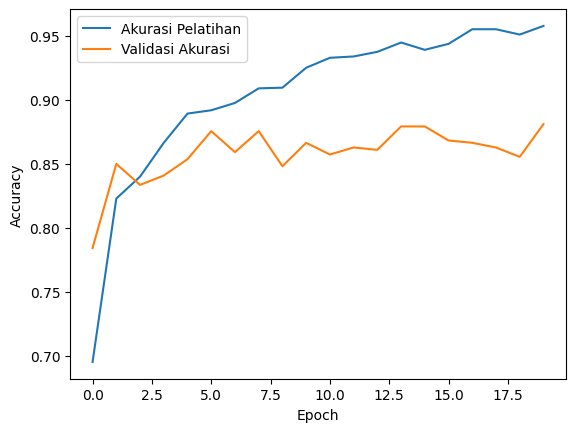

In [ ]:
plt.plot(history.history["accuracy"], label="Akurasi Pelatihan")
plt.plot(history.history["val_accuracy"], label="Validasi Akurasi")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

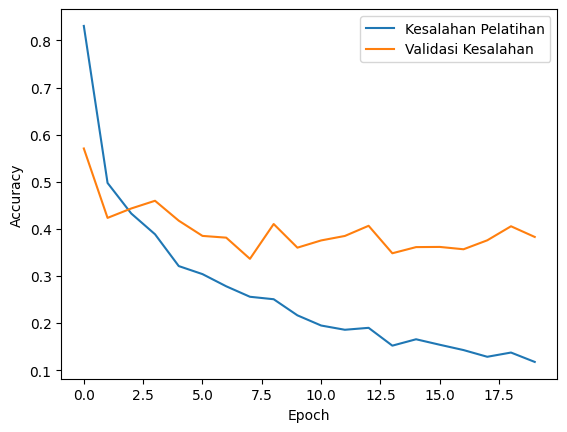

In [ ]:
plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(train_images, verbose=0)
print(f'Train Accuracy: {train_acc}')

In [ ]:
vall_loss, vall_acc = model.evaluate(vall_images, verbose=0)
print(f'Vall Accuracy: {vall_acc}')

In [ ]:
test_loss, test_acc = model.evaluate(test_images, verbose=0)
print(f'Test Accuracy: {test_acc}')

1/1 [==============================] - 1s 1s/step


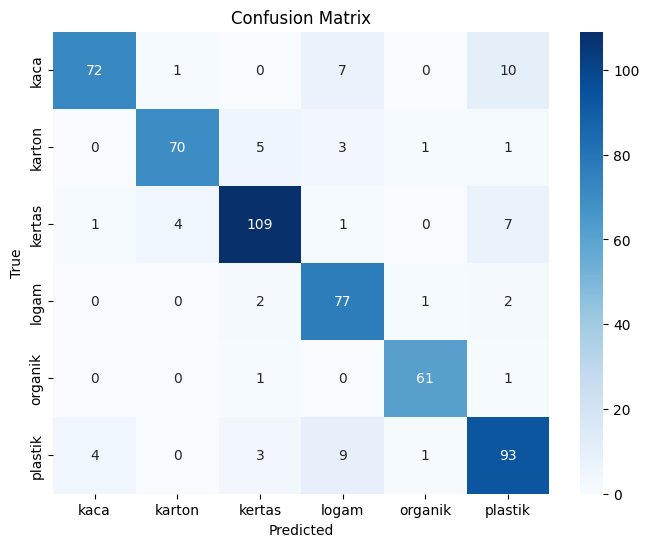

Classification Report:
               precision    recall  f1-score   support

        kaca       0.94      0.80      0.86        90
      karton       0.93      0.88      0.90        80
      kertas       0.91      0.89      0.90       122
       logam       0.79      0.94      0.86        82
     organik       0.95      0.97      0.96        63
     plastik       0.82      0.85      0.83       110

    accuracy                           0.88       547
   macro avg       0.89      0.89      0.89       547
weighted avg       0.89      0.88      0.88       547



In [ ]:
true_labels = []
predicted_labels = []

for _ in range(len(val_images)):
    batch_images, batch_labels = next(val_images)
    predictions = model.predict(batch_images)
    true_labels.extend(np.argmax(batch_labels, axis=1))
    predicted_labels.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

classification_rep = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", classification_rep)

In [ ]:
from google.colab import output
from IPython.display import display, Javascript, Image
from base64 import b64decode
import cv2
import numpy as np
import tensorflow as tf
from keras.preprocessing import image

dataset = pd.read_csv("dataset.csv")

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        takePhoto({quality});
    ''')
    display(js)
    data = output.eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

photo_filename = take_photo()

preprocessed_image = preprocess_image(photo_filename)

predictions = model.predict(preprocessed_image)

predicted_class = np.argmax(predictions)

class_indices = train_images.class_indices
class_names = list(class_indices.keys())
predicted_class_name = class_names[predicted_class]

print(f'Sampah {predicted_class_name}')

for index, row in dataset.iterrows():
    if row['jenis_sampah'] == predicted_class_name:
        print(f"Jenis Sampah: {row['jenis_sampah']}")
        print(f"Cara Penanganan: {row['cara_penanganan']}")
        print(f"Produk: {row['produk']}")
        print(f"Detail Produk: {row['detail_produk']}")


FileNotFoundError: [Errno 2] No such file or directory: 'dataset.csv'

4. Model Evaluation

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
  f.write(tflite_model)